## Farmland Coverage Analysis

This notebook demonstrates how to use a Visual Prompting model to analyze the area coverage of different types of land or structures on satellite images.

In particular, we are going to show you:

1. How to use the `Predictor` class to extract the segmentation mask
2. How to visualize the segmentation mask
3. How to extract the percentage pixel coverage and visualize it in a pie chart

### Installation

In [1]:
!pip install landingai

Obtaining file:///Users/asia/work/repos/landingai-python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for landingai (pyproject.toml) ... done
  Created wheel for landingai: filename=landingai-0.0.40-py3-none-any.whl size=4424 sha256=e5c9f30990144126234944e03bc8ddc721f91bade3f58f517a50b570205a2ba4
  Stored in directory: /private/var/folders/cv/kdkz6y_55z1blffx_f42w6zh0000gn/T/pip-ephem-wheel-cache-qw6dcxys/wheels/57/df/6e/917cfef370ef8a31e12c5b0a81541f8aa462c4f83c9ade0780
Successfully built landingai
  Attempting uninstall: landingai
    Found existing installation: landingai 0.0.40
    Uninstalling landingai-0.0.40:
      Successfully uninstalled landingai-0.0.40

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Prerequisite: Deploy a Visual Prompting Model

Before performing the coverage analsis, we have already trained a Visual Prompting model in LandingLens, and deployed it to a web endpoint via [Cloud Deployment](https://support.landing.ai/landinglens/docs/cloud-deployment).

The following cell includes the credentials needed to access the model and its endpoint: endpoint_id, api_key, and api_secret.

In [2]:
#@title Set the following variables as needed for your setup
api_key = "v7b0hdyfj6271xy2o9lmiwkkcbdpvt1"
api_secret = "ao6yjcju7q1e6u0udgwrgknhrx6m4n1o48z81jy6huc059gne047l4fq3u1cgq"
endpoint_id = "63035608-9d24-4342-8042-e4b08e084fde"

### Load Images

Here, we load three test images for the coverage analysis.

In [3]:
import numpy as np
from PIL import Image as PILImage

images = [
    np.asarray(PILImage.open("sample_images/1196.png")),
    np.asarray(PILImage.open("sample_images/1514.png")),
    np.asarray(PILImage.open("sample_images/1526.png"))
]

### Example Image

Let's take a look at one of the test images.

The model is trained to detect four classes:

1. Green field
2. Brown field
3. Trees
4. Structure

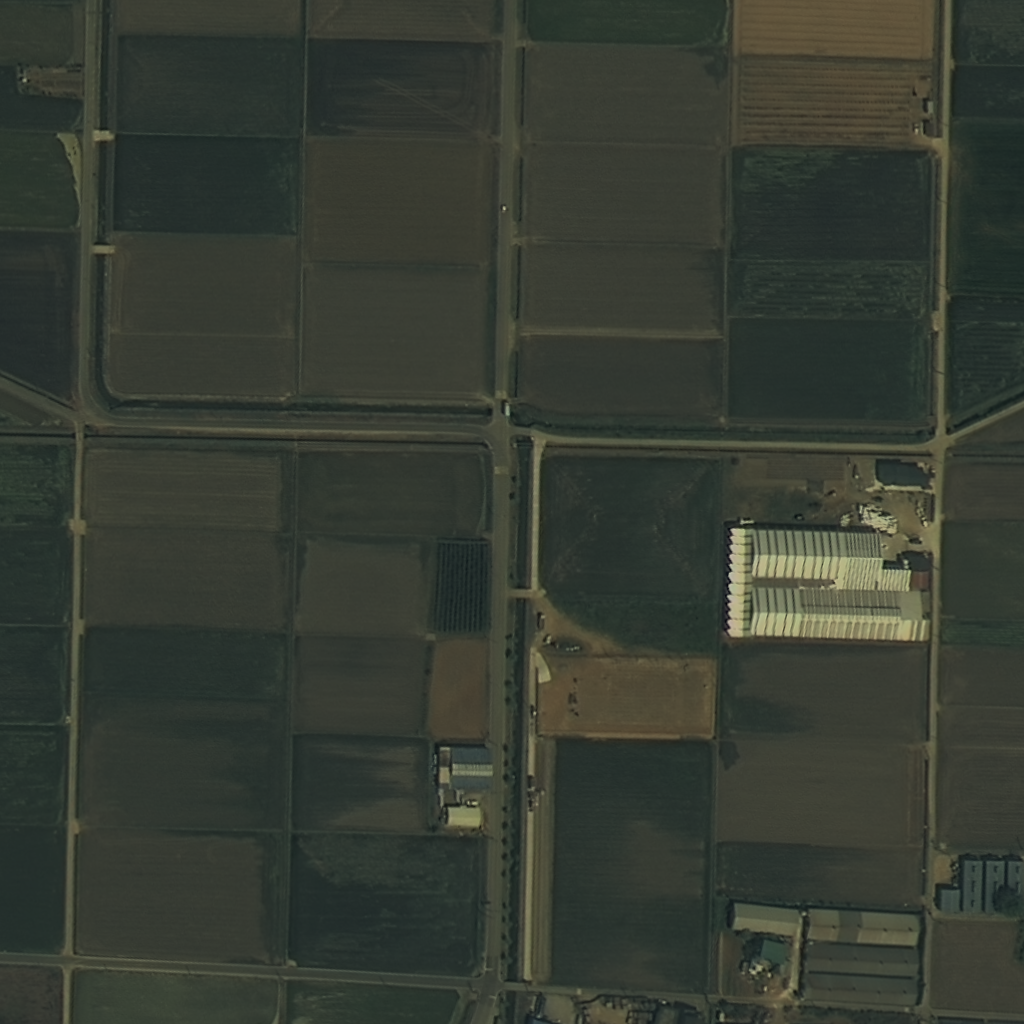

In [4]:
display(PILImage.fromarray(images[0]))

### Run Inference

In the following cell, we use the `Predictor` call to get the predicted segmentation masks for each image.

The predictor returns a list of `SegmentationPrediction` instances for each image.

We collect all of the prediction results into a list for further processing. 

In [5]:
from landingai.predict import Predictor

predictor = Predictor(endpoint_id, api_key, api_secret)
predictions = []
for img in images:
        predictions.extend(predictor.predict(img))

### Example Image with Prediction

Before moving forward, it's helpful to do a sanity check to see if the prediction result looks reasonable to you.  

To do that, we get the predictions of a single image, and visualize it like below.

Note: For this demo, we didn't spend time on improving model performance, so the segmentation mask may not be perfect.

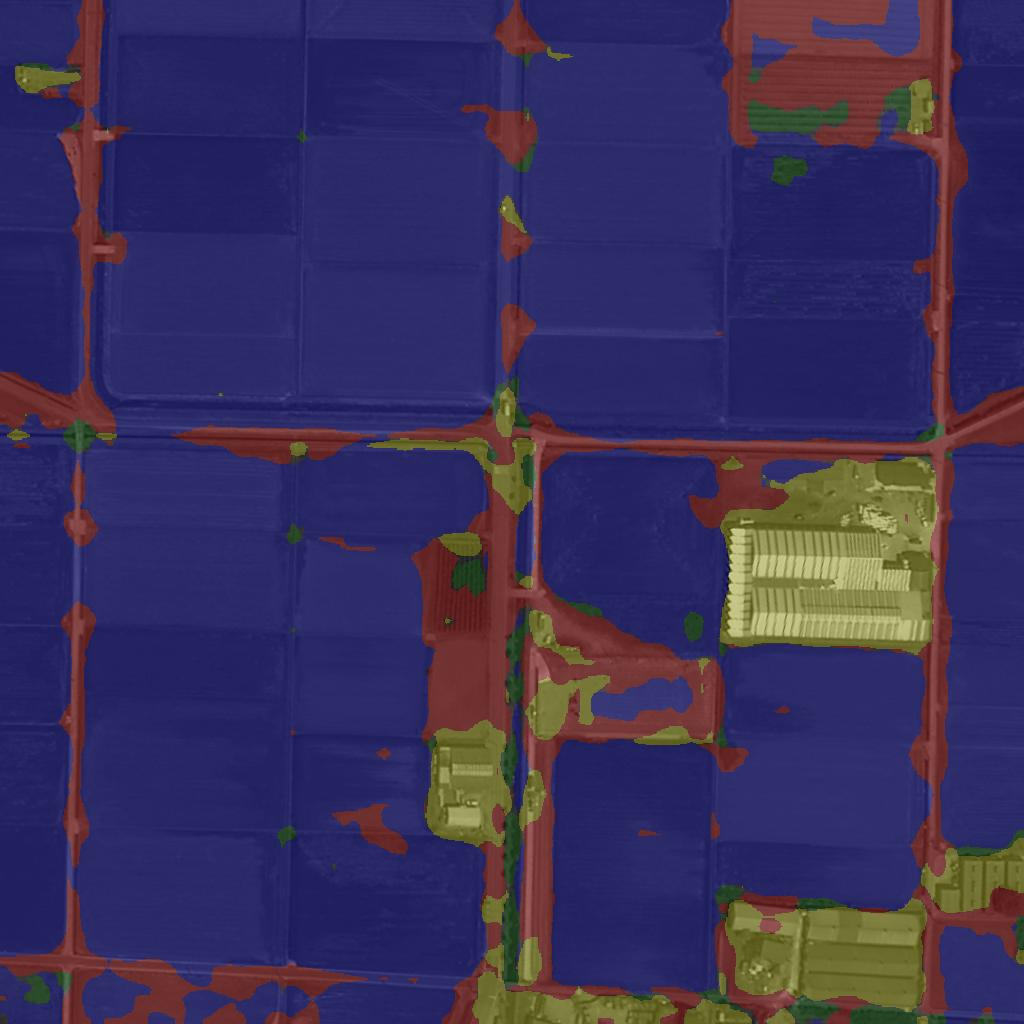

In [6]:
from landingai.visualize import overlay_predictions

predictions = predictor.predict(images[0])
color_map = {
    "Trees": "green",
    "Structure": "yellow",
    "Brown Field": "red",
    "Green Field": "blue",
}
options = {
    "color_map": color_map
}
display(overlay_predictions(predictions, images[0], options=options))

### Post-Processing: Compute the Coverage of Each Class

Now we that have collected a list of predictions (segmentation masks) we can call the `segmentation_class_pixel_coverage()` API to calculate the percentage of the pixel coverage of each class over all the images.

The output (`coverage`) is a dictionary where the key is the predicted class index, and the value is a tuple of the coverage percentage and the predicted class name.

The coverage percentage is calculated as follow:

`(number of predicted pixels for this class) / (total number of pixels)`

Note: Alternatively, we can also get the absolute coverage value (the number of predicted pixels for each class) by running `segmentation_class_pixel_coverage(predictions, coverage_type='absolute')`. See the API doc in `postprocess.py` for more details.

In [7]:
from landingai.postprocess import segmentation_class_pixel_coverage

coverage = segmentation_class_pixel_coverage(predictions)
coverage

{3: (0.7484035491943359, 'Green Field'),
 4: (0.14313411712646484, 'Brown Field'),
 5: (0.016084671020507812, 'Trees'),
 6: (0.08507537841796875, 'Structure')}

### Visualize the Predictions in a Pie Chart

Now we that have the coverage data, we can process it to see the predictions in a pie chart.

In [8]:
import matplotlib.pyplot as plt

def generate_pie_chart(data: dict[int, (float, str)], color_map: dict[str, str]) -> None:
    """Generate a pie chart from the coverage data"""

    labels = [val[1] for val in data.values()]
    colors = [color_map[label] for label in labels]
    sizes = [val[0] for val in data.values()]
    unclassified_pixels = 1 - sum(sizes)
    sizes.append(unclassified_pixels)
    labels.append("unclassified")
    colors.append("gray")
    _, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=90)

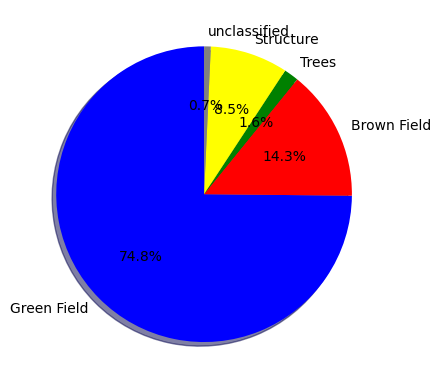

In [9]:
generate_pie_chart(coverage, color_map=color_map)